# TDE_color and TDE_color+u metrics

This notebook demonstrates how to use TDEsMonteMetric to calculate what fraction of input TDE lightcurves would be detected with two different sets of detection requirements:
  - TDE_color: tracks the color evolution of a TDE
  - TDE_color+u: tracks the color evolution of a TDE with requirement of at least 2 u-band observations during 2 weeks of light curve evolution
  
The input TDE is a fast and faint event at z=0.1.
    
Paired with a spatial slicer, one can obtain the skymap or the observed light curve. 

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.utils as utils

In [2]:
# Monte Carlo approach to detection of TDEs
# lixl@udel.edu

__all__ = ['TDEsMonteMetric']

class TDEsMonteMetric(BaseMetric):
    """Based on the transientMetric, but uses an ascii input file and provides option to write out lightcurve.
    
    Calculate what fraction of transients would be detected. Best paired with a spatial slicer.
    The lightcurve input is an ascii file per photometric band so that different lightcurve
    shapes can be implemented.

    Parameters
    ----------
    asciifile : str
        The ascii file containing the inputs for the lightcurve (per filter):
        File should contain three columns - ['ph', 'mag', 'flt'] -
        of phase/epoch (in days), magnitude (in a particular filter), and filter.
    
    detectSNR : dict, optional
        An observation will be counted toward the discovery criteria if the light curve SNR
        is higher than detectSNR (specified per bandpass).
        Values must be provided for each filter which should be considered in the lightcurve.
        Default is {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}
    
    Light curve parameters
    -------------
    epochStart: float
        The start epoch in ascii file.
        
    peakEpoch: float
        The epoch of the peak in ascii file.

    nearPeakT: float
        The days near peak.  Epoches from (peakEpoch - nearPeakT/2) to (peakEpoch + nearPeakT/2) 
        is considered as near peak.
    
    nPhaseCheck: float
        Number of phases to check.
    

    Condition parameters
    --------------
    nObsTotal: dict
        Minimum required total number of observations in each band.

    nObsPrePeak: float
        Number of observations before peak.

    nObsNearPeak: dict
        Minimum required number of observations in each band near peak.

    nFiltersNearPeak: float
        Number of filters near peak.

    nObsPostPeak: dict
        Minimum required number of observations in each band post peak.

    nFiltersPostPeak: float
        Number of filters after peak. 


    Output control parameters
    --------------
    dataout : bool, optional
        If True, metric returns full lightcurve at each point. Note that this will potentially
        create a very large metric output data file. 
        If False, metric returns the number of transients detected.

    """

    def __init__(self, asciifile, metricName = 'TDEsMonteMetric', 
    			 mjdCol = 'expMJD', m5Col = 'fiveSigmaDepth', filterCol = 'filter', 
                 detectSNR = {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 eventRate = 0.2,
                 epochStart = 0, peakEpoch = 0, nearPeakT=5, postPeakT=14,
                 nObsTotal = {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 nObsPrePeak = 0,
                 nObsNearPeak = {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                 nFiltersNearPeak = 0, 
                 nObsPostPeak = {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 nFiltersPostPeak = 0, 
                 dataout=False, **kwargs):
        
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.detectSNR = detectSNR
        self.dataout = dataout

        # event rate
        self.eventRate = eventRate
        
        # light curve parameters
        self.epochStart = epochStart
        self.peakEpoch = peakEpoch
        self.nearPeakT = nearPeakT
        self.postPeakT = postPeakT

        # condition parameters
        self.nObsTotal = nObsTotal
        self.nObsPrePeak = nObsPrePeak
        self.nObsNearPeak = nObsNearPeak
        self.nFiltersNearPeak = nFiltersNearPeak
        self.nObsPostPeak = nObsPostPeak
        self.nFiltersPostPeak = nFiltersPostPeak

        # if you want to get the light curve in output you need to define the metricDtype as object
        if self.dataout:
            super(TDEsMonteMetric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                       metricDtype='object', units='', 
                                                       metricName='TDEsMonteMetric', **kwargs)
        else:
            super(TDEsMonteMetric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                       units='Fraction Detected', 
                                                       metricName='TDEsMonteMetric', **kwargs)
        self.read_lightCurve(asciifile)
    
        print('Finish initializing metric')

    def read_lightCurve(self, asciifile):
        
        if not os.path.isfile(asciifile):
            raise IOError('Could not find lightcurve ascii file %s' % (asciifile))

        self.lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])

    def make_lightCurve(self, time, filters):
                
        lcv_template = self.lcv_template
        
        lcMags = np.zeros(time.size, dtype=float)
        
        for f in set(lcv_template['flt']):
            fMatch_ascii = np.where(np.array(lcv_template['flt']) == f)[0]
            
            # Interpolate the lightcurve template to the times of the observations, in this filter.
            lc_ascii_filter = np.interp(time, np.array(lcv_template['ph'], float)[fMatch_ascii],
                                            np.array(lcv_template['mag'], float)[fMatch_ascii])
            lcMags[filters == f.decode("utf-8")] = lc_ascii_filter[filters == f.decode("utf-8")]
        
        return lcMags

    def snr2std(self, snr):
        std = 2.5 * np.log10(1 + 1/snr)
        return std 

    def run(self, dataSlice, slicePoint=None):
        """"Calculate the detectability of a transient with the specified lightcurve.

        If self.dataout is True, then returns the full lightcurve for each object instead of the total
        number of transients that are detected.

        Parameters
        ----------
        dataSlice : numpy.array
            Numpy structured array containing the data related to the visits provided by the slicer.
        
        slicePoint : dict, optional
            Dictionary containing information about the slicepoint currently active in the slicer.

        Returns
        -------
        float or list of dicts
            The total number of transients that could be detected. (if dataout is False)
            A dictionary with arrays of 'lcNumber', 'lcMag', 'detected', 'time', 'detectThresh', 'filter'
        """

        # Sort the entire dataSlice in order of time.  
        dataSlice.sort(order=self.mjdCol)
        survey_length = (dataSlice[self.mjdCol].max() - dataSlice[self.mjdCol].min()) # in days
        
        lcv_template = self.lcv_template
        transDuration = lcv_template['ph'].max() - lcv_template['ph'].min() # in days

        # how many event occured
        nLc = np.random.poisson(self.eventRate * survey_length)

        # generate nLc random start time of each light curve
        t0 = np.random.randint(0, int(survey_length)+1, nLc) + dataSlice[self.mjdCol].min()

        # dict to store output info
        lcDictList = []
        nDetected = 0

        # loop over each light curve
        for i, t0_i in enumerate(t0):
            # the index for ith light curve
            lcIdx = (dataSlice[self.mjdCol] >= t0_i) & (dataSlice[self.mjdCol] <= t0_i + transDuration)

            lcMjd = dataSlice[self.mjdCol][lcIdx]
            lcEpoch = lcMjd - t0_i + self.epochStart
            lcFilters = dataSlice[self.filterCol][lcIdx]
            
            flt = ['u', 'g', 'r', 'i', 'z', 'y']

            # make light curve
            lcMags = self.make_lightCurve(lcEpoch, lcFilters)
            
            # get SNR
            m5 = dataSlice[self.m5Col][lcIdx]
            lcSNR = utils.m52snr(lcMags, m5)

            # check SNR for each filter
            lcAboveThresh = np.zeros(len(lcSNR), dtype=bool)
            for f in np.unique(flt):
                filtermatch = np.where(lcFilters==f)
                lcAboveThresh[filtermatch] = np.where(lcSNR[filtermatch]>=self.detectSNR[f], True, False)

            # ----------check all conditions-----------
            # first assume lcDetect = True, if one condition fails, set to False
            lcDetect = True

            # check total number of observations for each band
            for f in np.unique(flt):
                filtermatch = np.where(lcFilters==f)
                if len(np.where(lcAboveThresh[filtermatch])[0]) < self.nObsTotal[f]:
                    lcDetect = False
                    
            # number of observations before peak
            prePeakCheck = (lcEpoch < self.peakEpoch - self.nearPeakT/2)
            prePeakIdx = np.where(prePeakCheck == True)
            if len( np.where(lcAboveThresh[prePeakIdx])[0] ) < self.nObsPrePeak:
                lcDetect = False
                
            # check number of observations near peak for each band
            nearPeakCheck = (lcEpoch >= self.peakEpoch - self.nearPeakT/2) & (lcEpoch <= self.peakEpoch + self.nearPeakT/2) 
            nearPeakIdx = np.where(nearPeakCheck==True)
            # near peak obs for each band    
            for f in np.unique(flt):
                nearPeakIdx_f = np.intersect1d( nearPeakIdx, np.where(lcFilters==f) )
                if len( np.where(lcAboveThresh[nearPeakIdx_f])[0] ) < self.nObsNearPeak[f]:
                    lcDetect = False

            # check number of filters near peak
            filtersNearPeakIdx = np.intersect1d(nearPeakIdx, np.where(lcAboveThresh)[0])
            if len( np.unique(lcFilters[filtersNearPeakIdx]) ) < self.nFiltersNearPeak:
                lcDetect = False
            
            # check number of observations post peak for each band
            postPeakCheck = (lcEpoch >= self.peakEpoch + self.nearPeakT/2) & (lcEpoch <= self.peakEpoch + self.nearPeakT/2 + self.postPeakT )
            postPeakIdx = np.where(postPeakCheck == True)
            # post peak obs for each band    
            for f in np.unique(flt):
                postPeakIdx_f = np.intersect1d( postPeakIdx, np.where(lcFilters==f) )
                if len( np.where(lcAboveThresh[postPeakIdx_f])[0] ) < self.nObsPostPeak[f]:
                    lcDetect = False

            # check number of filters post peak
            filtersPostPeakIdx = np.intersect1d(postPeakIdx, np.where(lcAboveThresh)[0])
            if len( np.unique(lcFilters[filtersPostPeakIdx]) ) < self.nFiltersPostPeak:
                lcDetect = False

            # ----------------------

            # values for output
            if lcDetect==True:
                nDetected += 1

            lcDict = {'lcN': i, 'lcMjd': lcMjd, 'lcEpoch': lcEpoch, 'lcFilters': lcFilters,
              'lcMags': lcMags, 'm5': m5, 'lcSNR': lcSNR, 'lcMagsStd': self.snr2std(lcSNR), 'lcAboveThresh':lcAboveThresh,
              'prePeakCheck': prePeakCheck, 'nearPeakCheck': nearPeakCheck, 'postPeakCheck': postPeakCheck,
              'detected': lcDetect}
    
            lcDictList.append(lcDict)

        if self.dataout:

            return lcDictList
        else:   
            #return float(nDetected / nTransMax) if nTransMax!=0 else 0.
            return float(nDetected/nLc) if nLc!=0 else 0. 

## Minimum requirements for a detection

The TDEsAsciiMetric provides some requirements to be met in order to have a positive TDE detection.

- nObsTotal: Total number of observations in each band.
- nObsPrePeak: Number of observations before peak.
- nObsNearPeak: Number of observations in each band near peak.
- nFiltersNearPeak: Number of filters near peak.
- nObsPostPeak: Number of observations in each band after peak.
- nFiltersPostPeak: Number of filters after peak.

**Minimum requirement for detection TDEs** proposed by [Sjoert van Velzen](https://github.com/sjoertvv)

TDE_color:
- one detection before peak in any band to make sure we can roughly resolve the time/flux at peak,  set nObsPrePeak=1;
- detections in three different bands within 10 days of peak to measure the color at peak, set nFiltersNearPeak=3, and nearPeakT=10;
- detections at least two bands post peak within two weeks to measure the change of color, set nFiltersPostPeak=2, and postPeakT=14.

TDE_color+u:
- one detection before peak in any band to make sure we can roughly resolve the time/flux at peak,  set nObsPrePeak=1;
- one detection in u and one detection in r band near peak, set nObsNearPeak = {'u': 1, 'g': 0, 'r': 1, 'i': 0, 'z': 0, 'y': 0} and nearPeakT=10;
- one detection in u and one detection in r band after peak, set nObsPostPeak = {'u': 1, 'g': 0, 'r': 1, 'i': 0, 'z': 0, 'y': 0} and postPeakT=14.

#### Parameters for TDE_color metric

| parameters | value | meaning | 
| :---       | :---  | :---    |
| eventRate  | 0.3   |  Three events may occur per 10 days |
| epochStart | -22   |  Start epoch of input light curve |
| peakEpoch  | 0     |  Peak epoch of input light curve  |
| nearPeakT  | 10    |  Within 10 days around peakEpoch are considered as near peak (peak +- 5 days)|
| postPeakT  | 14    |  Within two weeks after peakEpoch are considered as post peak (from peak + nearPeakT/2 days on for 2 weeks)|
| nObsTotal  |{'u': 0, ...}| Number of total observations in each band |
| nObsPrePeak| 1     | Number of observations before peak |
|nObsNearPeak |{'u': 0, ...}| Number of observations in each band |
|nFiltersNearPeak | 3 | Number of filters near peak |
|nObsPostPeak | {'u': 0, ...} | Number of observations after peak |
|nFiltersPostPeak | 2 | Number of filters after peak |

#### Parameters for TDE_color+u metric

| parameters | value | meaning | 
| :---       | :---  | :---    |
| eventRate  | 0.3   |  Three events may occur per 10 days |
| epochStart | -22   |  Start epoch of input light curve |
| peakEpoch  | 0     |  Peak epoch of input light curve  |
| nearPeakT  | 10    |  Within 10 days around peakEpoch are considered as near peak (peak +- 5 days)|
| postPeakT  | 14    |  Within two weeks after peakEpoch are considered as post peak (from peak + nearPeakT/2 days on for 2 weeks)|
| nObsTotal  |{'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}| Number of total observations in each band |
| nObsPrePeak| 1     | Number of observations before peak |
|nObsNearPeak |{'u': 1, 'g': 0, 'r': 1, 'i': 0, 'z': 0, 'y': 0}| Number of observations in each band |
|nFiltersNearPeak | 0 | Number of filters near peak |
|nObsPostPeak | {'u': 1, 'g': 0, 'r': 1, 'i': 0, 'z': 0, 'y': 0} | Number of observations after peak |
|nFiltersPostPeak | 0 | Number of filters after peak |

#### Load the light-curve file and set the requirements

In [3]:
# light curve file
asciifile = 'TDEfaintfast_z0.1.dat'

# query columns 
mjdCol = 'observationStartMJD'
m5Col = 'fiveSigmaDepth'
filterCol = 'filter'
detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}

# set event rate
eventRate = .3

# set light curve parameters
epochStart = -22
peakEpoch = 0
nearPeakT = 10
postPeakT = 14 # two weeks

In [4]:
#requirements for TDE_color
nObsTotal_color = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nObsPrePeak_color = 1
nObsNearPeak_color = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nFiltersNearPeak_color = 3
nObsPostPeak_color = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0} 
nFiltersPostPeak_color = 2

#requirements for TDE_color+u
nObsTotal_u = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nObsPrePeak_u = 1 #1 obs pre-peak is probably quite neccesary though
nObsNearPeak_u = {'u': 1, 'g': 0, 'r': 1, 'i': 0, 'z': 0, 'y': 0}
nFiltersNearPeak_u = 0
nObsPostPeak_u = {'u': 1, 'g': 0, 'r': 1, 'i': 0, 'z': 0, 'y': 0}
nFiltersPostPeak_u = 0

#### Define a function to plot light curves

In [5]:
# plot light curve
def plotlc(dataSlice, time_key='time', mag_key='mag', filter_key='filter', err_key = None,
          peakEpoch=None, nearPeakT=None, postPeakT=None):
    # Input: dataSlice, pandas DataFrame or numpy ndarray
    
    colors = {'u': 'indigo', 'g': 'mediumvioletred', 'r': 'red', 'i': 'orange', 'z': 'limegreen', 'y': 'teal'}
    
    plt.figure(figsize=(10, 6))
    
    for f in np.unique(dataSlice[filter_key]):
        fmatch = dataSlice[filter_key]==f
        time = dataSlice[time_key][fmatch]
        mag = dataSlice[mag_key][fmatch]
        
        # draw a vertical line to denote pre/near/post peak
        if peakEpoch!=None:
            plt.axvline(x=peakEpoch, linestyle='-', linewidth=1, color='k', alpha=0.1)
            plt.axvline(x=peakEpoch-nearPeakT/2, linestyle='--', linewidth=1, color='k', alpha=0.1)
            plt.axvline(x=peakEpoch+nearPeakT/2, linestyle='--', linewidth=1, color='k', alpha=0.1)
            plt.axvline(x=peakEpoch+nearPeakT/2+postPeakT, linestyle='dotted', linewidth=1, color='k', alpha=0.1)
        
        if err_key!=None:
            mag_err = dataSlice[err_key][fmatch]
            plt.errorbar(time, mag, yerr=mag_err, color=colors[f], fmt='.', label=f)
        else:
            plt.scatter(time, mag, color=colors[f], marker='.', label=f)

    plt.legend()
    plt.xlabel('days')
    plt.ylabel('mag')
    plt.ylim(plt.ylim()[::-1])

#### Plot the example light curve

Text(0.5, 0, 'epoch [days] \n An example of an input lightcurve template. \n')

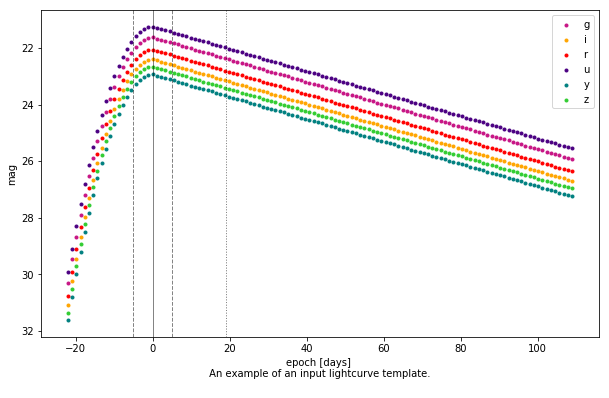

In [6]:
asciifile = 'TDEfaintfast_z0.1.dat'

lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])

df = pd.DataFrame()
df['ph'] = lcv_template['ph']
df['mag'] = lcv_template['mag']
df['flt'] = lcv_template['flt'].astype(str)

plotlc(df, time_key='ph', mag_key='mag', filter_key='flt', 
       peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of an input lightcurve template. \n' )

## Load opsim database file

In [24]:
# connect to opsim database
opsdb_baseline = db.OpsimDatabase('/Users/katjabricman/Documents/Research/lsst_database/FBS_1.4_runs/baseline/baseline_v1.4_10yrs.db')
opsim_name = 'baseline_v1.4_10yrs'
# create output directory for baseline opsim
outDir = 'outdir/' + opsim_name
resultsDb = db.ResultsDb(outDir=outDir)

# TDE_color metric 

### skymap

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 for columns ['observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'filter', 'fieldDec']
Found 343911 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.
monopole: 0.0256388  dipole: lon: 156.21, lat: -50.3173, amp: 0.0261004
Plotting complete.


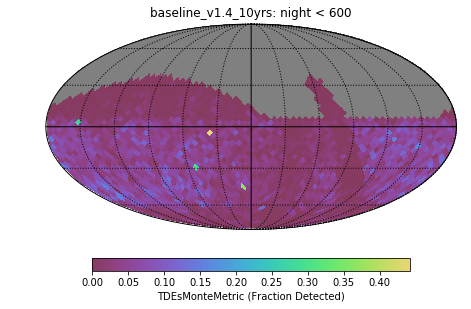

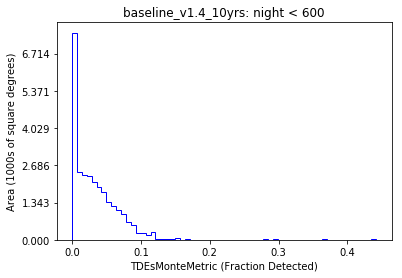

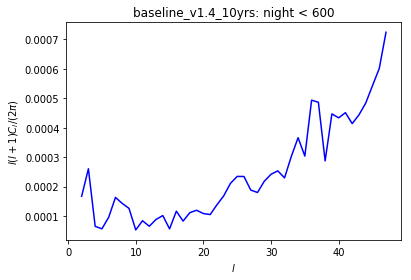

In [8]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal_color, nObsPrePeak=nObsPrePeak_color, 
                              nObsNearPeak=nObsNearPeak_color, nFiltersNearPeak=nFiltersNearPeak_color, 
                              nObsPostPeak=nObsPostPeak_color, nFiltersPostPeak=nFiltersPostPeak_color,
                              dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<600' 

transmetricSky = metricBundles.MetricBundle(transmetric, slicer, sqlconstraint,
                                            plotDict={'title': opsim_name + ': night < 600'})

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_baseline, outDir=outDir, 
                                        resultsDb=resultsDb)

group.runAll()
group.plotAll(closefigs=False)


In [9]:
baseline_skymap_color = transmetricSky.metricValues

In [10]:
# get the a random ipix where the metric value is larger than 1% and transform it to ra,dec
ipix = np.random.choice(np.where(baseline_skymap_color>=0.01)[0])
coords = hp.pix2ang(ipix=ipix, nside=16, lonlat=True)
coords

(275.625, -16.95776330000413)

### light curve example

In [11]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal_color, nObsPrePeak=nObsPrePeak_color, 
                              nObsNearPeak=nObsNearPeak_color, nFiltersNearPeak=nFiltersNearPeak_color, 
                              nObsPostPeak=nObsPostPeak_color, nFiltersPostPeak=nFiltersPostPeak_color,
                              dataout=True)

# ra,dec of ipix where metric value > 0.01 giving a larger probability a TDE is detected there
ra = coords[0]
dec = coords[1]
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<3625'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_baseline, outDir=outDir, 
                                        resultsDb=resultsDb)
group.runAll()

Finish initializing metric
Querying database SummaryAllProps with constraint night<3625 for columns ['observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'filter', 'fieldDec']
Found 2139664 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [12]:
# create a DataFrame from the output
output_dict_list = transmetricSky.metricValues.data[0] # 0 means 0th userpoint (ra,dec)
df = pd.DataFrame()
for d_ in output_dict_list:
    df = df.append(pd.DataFrame(d_))

#detected light curves (the ones that satisfied the requirements set above)
np.unique( df[df.detected]['lcN'] ) 

array([ 36, 128, 131, 576, 737, 796, 981])

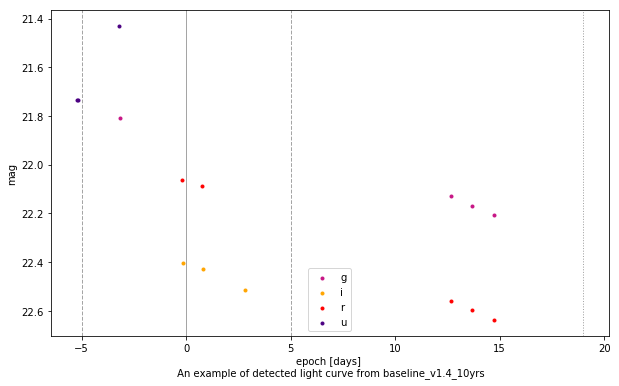

In [15]:
# plot a specific light curve  
plotlc(df[ (df.lcAboveThresh) & (df.lcN==np.random.choice(np.unique( df[df.detected]['lcN'] ) ))], 
       time_key='lcEpoch', mag_key='lcMags', filter_key='lcFilters', 
       err_key=None, peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of detected light curve from ' + opsim_name)
plt.show()

# TDE_color+u metric

### skymap

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 for columns ['observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'filter', 'fieldDec']
Found 343911 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.


/Users/katjabricman/lsst_stack/stack/miniconda3-4.5.12-1172c30/DarwinX86/sims_maf/2.13.0.sims-7-g78afd5a6/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/katjabricman/lsst_stack/stack/miniconda3-4.5.12-1172c30/DarwinX86/sims_maf/2.13.0.sims-7-g78afd5a6/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.00012031  dipole: lon: 82.6082, lat: -41.4468, amp: 0.000441304
Plotting complete.


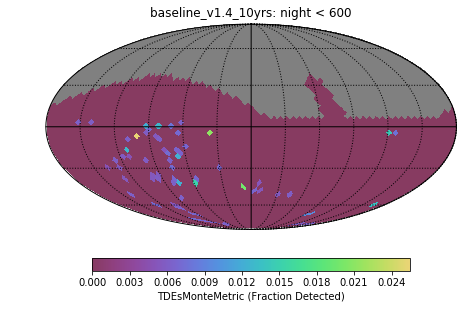

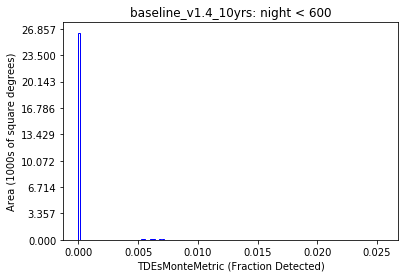

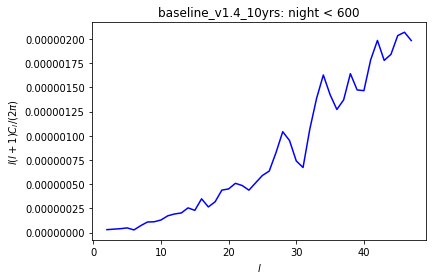

In [16]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal_u, nObsPrePeak=nObsPrePeak_u, 
                              nObsNearPeak=nObsNearPeak_u, nFiltersNearPeak=nFiltersNearPeak_u, 
                              nObsPostPeak=nObsPostPeak_u, nFiltersPostPeak=nFiltersPostPeak_u,
                              dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<600'

transmetricSky = metricBundles.MetricBundle(transmetric, slicer, sqlconstraint,
                                            plotDict={'title': opsim_name + ': night < 600'})

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_baseline, outDir=outDir, 
                                        resultsDb=resultsDb)

group.runAll()
group.plotAll(closefigs=False)

In [17]:
baseline_skymap_u = transmetricSky.metricValues

In [19]:
np.where(baseline_skymap_u>=0.01)[0]

/Users/katjabricman/lsst_stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


array([1518, 1520, 1638, 1674, 1714, 1972, 2092, 2538, 2541, 2593, 2873])

In [20]:
# get the a random ipix where the metric value is larger than 1% and transform it to ra,dec
#ipix = np.random.choice(np.where(baseline_skymap>=0.01)[0])
coords = hp.pix2ang(ipix=1518, nside=16, lonlat=True)
coords

(81.56249999999999, 0.0)

### light curve example

In [21]:
# get skymap by set dataout=False and use HealpixSlicer()
transmetric = TDEsMonteMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, eventRate=eventRate,
                              epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT,
                              nObsTotal= nObsTotal_u, nObsPrePeak=nObsPrePeak_u, 
                              nObsNearPeak=nObsNearPeak_u, nFiltersNearPeak=nFiltersNearPeak_u, 
                              nObsPostPeak=nObsPostPeak_u, nFiltersPostPeak=nFiltersPostPeak_u,
                              dataout=True)

# ra,dec of ipix where metric value > 0.01 giving a larger probability a TDE is detected there
ra = coords[0]
dec = coords[1]
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<3625'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_baseline, outDir=outDir, 
                                        resultsDb=resultsDb)
group.runAll()

Finish initializing metric
Querying database SummaryAllProps with constraint night<3625 for columns ['observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'filter', 'fieldDec']
Found 2139664 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [22]:
# create a DataFrame from the output
output_dict_list = transmetricSky.metricValues.data[0] # 0 means 0th userpoint (ra,dec)
df = pd.DataFrame()
for d_ in output_dict_list:
    df = df.append(pd.DataFrame(d_))

#detected light curves (the ones that satisfied the requirements set above)
np.unique( df[df.detected]['lcN'] ) 

array([], dtype=int64)

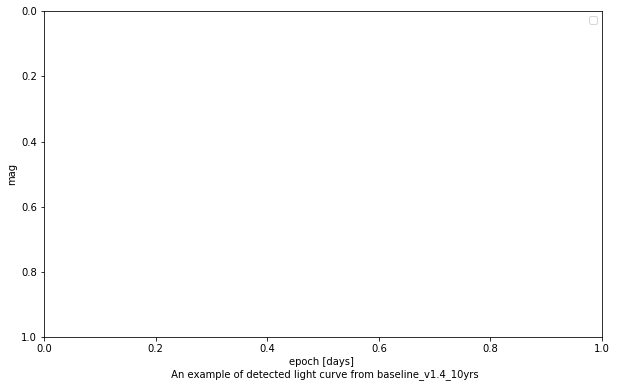

In [23]:
# plot a specific light curve  
plotlc(df[ (df.lcAboveThresh) & (df.lcN==9)], time_key='lcEpoch', mag_key='lcMags', filter_key='lcFilters', 
       err_key=None, peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of detected light curve from ' + opsim_name)
plt.show()
